In [1]:
import numpy as np
import csv
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
#from tensorflow.examples.tutorials.mnist import input_data
from torch.autograd import Variable
import sklearn.metrics as metrics
import pickle
import os
import numpy.linalg as la
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor()])#,transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
train_set = dset.MNIST('/home/daiict/Desktop/udit/C-GAN./data' ,train=True, download= True,
                       transform = transform)
test_set = dset.MNIST('/home/daiict/Desktop/udit/C-GAN./data' ,train=False, download=True,
                       transform = transform)

In [17]:
batch_size = 100
no_classes = 10
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1000,shuffle=True)

print len(train_loader), len(test_loader)

ip_dim = 28*28
z_dim = 15

600 10


In [4]:
#### Encoder

class encoder(nn.Module):
    def __init__(self):
        super(encoder,self).__init__()
        self.l1 = nn.Linear(ip_dim,500)
        self.l2 = nn.Linear(500,500)
        self.l3 = nn.Linear(500,300)
        self.l4 = nn.Linear(300,300)
        self.l5 = nn.Linear(300,z_dim)
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = F.leaky_relu(self.l3(x))
        x = F.leaky_relu(self.l4(x))
        x = (self.l5(x))
        
        return x

### Decoder

class decoder(nn.Module):
    def __init__(self):
        super(decoder,self).__init__()
        self.l1 = nn.Linear(z_dim,300)
        self.l2 = nn.Linear(300,300)
        self.l3 = nn.Linear(300,500)
        self.l4 = nn.Linear(500,500)
        self.l5 = nn.Linear(500,ip_dim)
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = F.leaky_relu(self.l3(x))
        x = F.leaky_relu(self.l4(x))
        x = F.sigmoid(self.l5(x))
        
        return x

###  Discriminator

class disc(nn.Module):
    def __init__(self):
        super(disc,self).__init__()
        self.l1 = nn.Linear(z_dim,100)
        self.l2 = nn.Linear(100,100)
        self.l3 = nn.Linear(100,100)
        self.l4 = nn.Linear(100,1)
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = F.leaky_relu(self.l3(x))
        x = F.sigmoid(self.l4(x))
        
        return x
    
class disc2(nn.Module):
    def __init__(self):
        super(disc2,self).__init__()
        self.l1 = nn.Linear(ip_dim,500)
        self.l2 = nn.Linear(500,500)
        self.l3 = nn.Linear(500,100)
        self.l4 = nn.Linear(100,1)
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = F.leaky_relu(self.l3(x))
        x = F.sigmoid(self.l4(x))
        
        return x

In [23]:
def get_true_z(mean_z,label):
    
    noise = np.random.randn(batch_size,z_dim)
    label = label.numpy().reshape(batch_size,)
    #print noise.shape,label.shape
    #z = 0.1*noise + label*10
    
    z = 0.1*noise + mean_z[label]
    z = Variable(torch.FloatTensor(z)).cuda()
    return z
    #z = torch.add(noise,value=1,other=label)
    #z = Variable(z.cuda())

In [24]:
cuda = True
if(1==1):
    if cuda==True:
        Q = encoder().cuda()
        P = decoder().cuda()
        D = disc().cuda()
        D2 = disc2().cuda()
    else:
        Q = encoder()
        P = decoder()
        D = disc()
   
    Q_solver = optim.Adam(Q.parameters(),lr=1e-3)
    E_solver = optim.Adam(Q.parameters(),lr = 1e-3)
    
    P_solver = optim.Adam(P.parameters(),lr = 1e-3)
   
    D_solver = optim.Adam(D.parameters(),lr = 1e-3)
    D2_solver = optim.Adam(D2.parameters(),lr = 1e-3)
    #Q,P = train_model(Q,Q_solver,P,P_solver,D,D_solver,D2,D2_solver,batch_size,clustering = clustering)
    
 
    
    #return Q,P

### First set in Autoencoder mode

In [25]:
#def train_model(Q,Q_solver,P,P_solver,D,D_solver,D2,D2_solver,batch_size,clustering = clustering,mean_z = mean_z):
def train_model(mean_z=None):
    
    recon = []
    encode = []
    discriminate = []
    for it in range(2,500):
        x,y = next(iter(train_loader))
       
        x = x.view(batch_size,28*28)
        if(cuda==True):
            x = Variable(x.cuda())
            #label_info = Variable((add_label_info(y,batch_size)).type(torch.FloatTensor)).cuda()

        else:
            x = Variable(x)
            #label_info = Variable((add_label_info(y,batch_size)).type(torch.FloatTensor))

        z = Q(x)

        #Reconstruction

        #z_false = (torch.cat([z,label_info],1))
        
        x_recon = P(z)
        
        add_small = 1e-20
        
        if(it%1==0):
            CEL = F.binary_cross_entropy(x_recon,x)
            #CEL = criterion(x_recon, x)
        
            CEL.backward(retain_graph=True)
            Q_solver.step()
            P_solver.step()
        
            Q.zero_grad()
            P.zero_grad()
        if(it%25==0):
            print CEL.data[0]
            
            xtmp = x[0]
            ztmp = Q(xtmp)
            x_recon = P(ztmp)
            op = x_recon.cpu().data.numpy()
            op = op.reshape(28,28)
            plt.imshow(op)
            plt.show()

0.222640603781


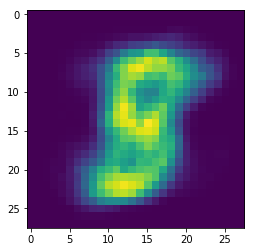

0.205619066954


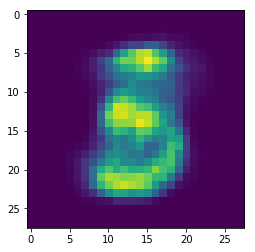

0.195462301373


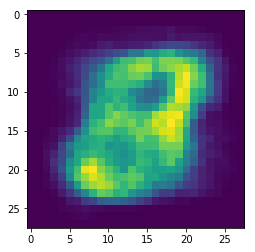

0.189338251948


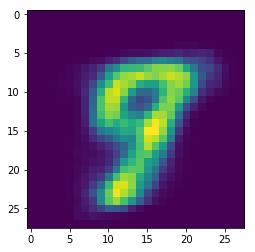

0.191386014223


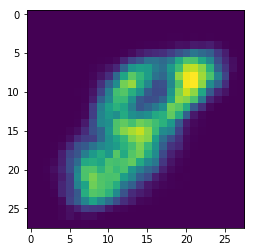

0.185267299414


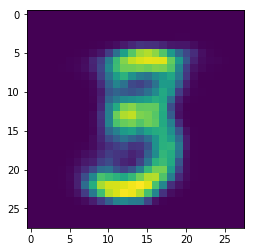

0.174501895905


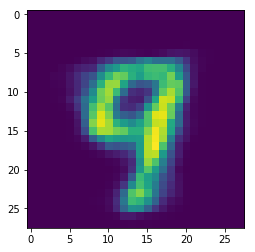

0.182253211737


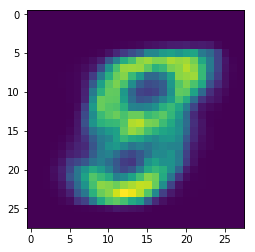

0.177183642983


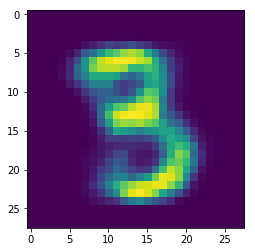

0.172119259834


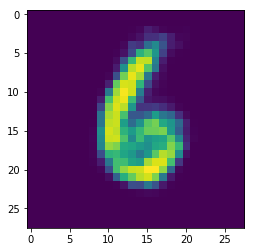

0.167623773217


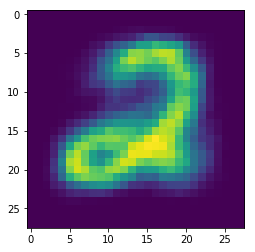

0.174218207598


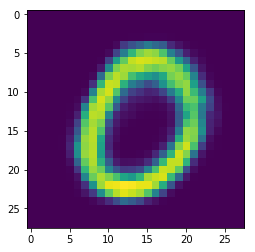

0.161226212978


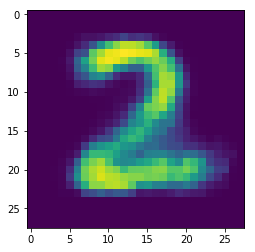

0.171064391732


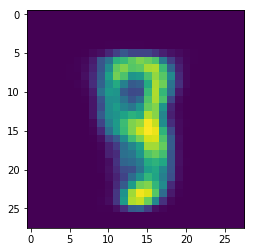

0.157302230597


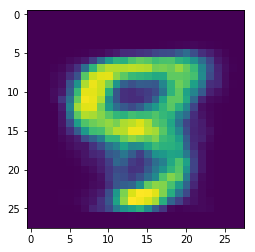

0.165687188506


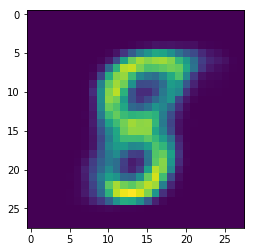

0.156460925937


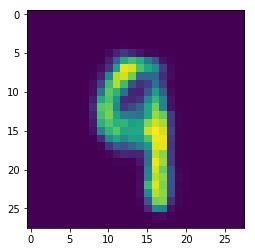

0.166634768248


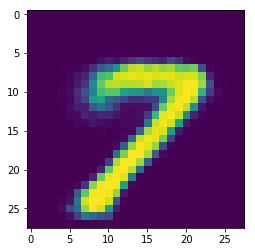

0.15495762229


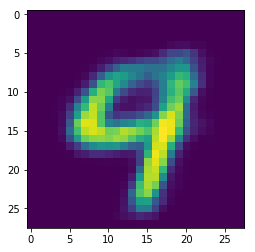

In [15]:
train_model()

In [26]:
def get_mean():
    x,y = next(iter(test_loader))
    y = y.cpu().numpy()
    x = x.view(x.size()[0],28*28)
    x = Variable(x.cuda())
    z = Q(x)
    z_np = z.cpu().data.numpy()
    mean_z = np.zeros((no_classes,z_dim))
    
    plt.figure(figsize=(8, 6)) 
           
    #plt.scatter(z_np[:, 0], z_np[:, 1],c = y)#,cmap=plt.cm.autumn)
    #plt.colorbar()
    #plt.grid()
    #plt.show()   
    for i in range(no_classes):
        mean_z[i] = np.mean(z_np[np.argwhere(y==i)],axis=0)
        #print(z_np[np.argwhere(y==i)])
    #plt.scatter(mean_z[:,0],mean_z[:,1],c=range(no_classes))
    #plt.show()
    
    return mean_z

### Forced Custering

In [30]:
for iter_ in range(20):
    for ep in range(200):
        x,y = next(iter(train_loader))
        mean_z1 = get_mean()
        x = x.view(batch_size,28*28)
        x = Variable(x.cuda())

        z_false = Q(x)
        z_true = get_true_z(mean_z1,y)
        
        d_false = D(z_false)
        d_true = D(z_true)
        
        add_small = 1e-15
        D_loss = -torch.mean(torch.log(d_true + add_small) + torch.log(1-d_false + add_small))
        D_loss.backward(retain_graph = True)
        D_solver.step()
    
        d_false = D(z_false)
        Q_loss = -torch.mean(torch.log(d_false + add_small))
        Q_loss.backward()
        Q_solver.step()
        
        
        
        if(ep%10==0):
            mean_z2 = get_mean()
            diff = np.linalg.norm(mean_z1-mean_z2)
            print D_loss.data[0],Q_loss.data[0]
            print("mean diff",diff)

1.56972706318 1.14152741432
('mean diff', 61.442165141760668)
5.55955076218 0.00816945079714
('mean diff', 110.55345787611732)
1.39262890816 2.14184308052
('mean diff', 75.402431978549828)
6.23388671875 5.59616565704
('mean diff', 118.51759137338202)
6.76596784592 0.0231141299009
('mean diff', 80.270742505145307)
5.65207624435 0.0180203635246
('mean diff', 1070.3465123020865)
4.82411146164 0.06271340698
('mean diff', 2158.9839134895697)
4.58355331421 5.025141716
('mean diff', 3011.3458968743021)
18.2411499023 0.0768572688103
('mean diff', 6123.898305861022)
7.05741024017 0.192920595407
('mean diff', 1623.2497696551268)
3.14753746986 0.0412084721029
('mean diff', 5677.2914063861535)
34.5387649536 -0.0
('mean diff', 13352.203244104156)
34.5387649536 -0.0
('mean diff', 15260.358559536404)
34.5387649536 -0.0
('mean diff', 40542.486386455661)
34.5387649536 -0.0
('mean diff', 133436.27553185317)
34.5387649536 -0.0
('mean diff', 562066.66081273451)
34.5387649536 -0.0
('mean diff', 411099.5065

KeyboardInterrupt: 

In [ ]:
        #recon.append(CEL)

# ## use a discriminator to learn the reconstruction loss also discriminatively
#         if(it%2==0):
#             Dx_false = D2(x_recon)
#             Dx_true = D2(x)
            
#             D2_loss = -torch.mean(torch.log(Dx_true + add_small) + torch.log(1 - Dx_false + add_small))
#             D2_loss.backward(retain_graph=True)
#             D2_solver.step()
#             D2.zero_grad()
        
#             Dx_false = D2(x_recon)
            
#             recon_loss = -torch.mean(torch.log(Dx_false)) + 0.5*F.binary_cross_entropy(x_recon,x)
#             recon_loss.backward(retain_graph=True)
#             Q_solver.step()
#             P_solver.step()
#             Q.zero_grad()
#             P.zero_grad()
            
        

        
        
        
        
        
        #Discriminator
       
        
        if cuda==True:
            if mean_z is not None:
                z_true = get_true_z(mean_z,y).cuda()
            else:
                z_true = Variable(torch.randn(batch_size,z_dim).cuda())
                
        else:
            if mean_z is None:
                z_true = get_true_z(mean_z,y)
            else:
                z_true = Variable(torch.randn(batch_size,z_dim))

        z_true = Variable(torch.cat([z_true,label_info],1).data).cuda()
        z_true_op = D(z_true)
        
        z_false_op = D(z_false)
        
        
        if(it%1==0):
    
            loss_d = -torch.mean(torch.log(z_true_op + add_small) + torch.log(1 - z_false_op + add_small))
            loss_d.backward(retain_graph=True)
            D_solver.step()
            D.zero_grad()
            discriminate.append(loss_d)

    #Updating the encoder
        G_loss = -torch.mean(torch.log(z_false_op+1e-20))
        G_loss.backward(retain_graph=True)
        Q_solver.step()
        Q_solver.zero_grad()
        encode.append(G_loss)
        
        
    ## occasionally update the encoder with MSE loss
    
#         if(it%25==0):
#             tmp_loss = nn.MSELoss()(z_false,z_true)
#             print('tmp_loss:',tmp_loss.data[0])
#             tmp_loss = 1e-3*tmp_loss
#             tmp_loss.backward()
#             Q_solver.step()
#             Q_solver.zero_grad()

        
        
        if(it%25==0):
            #print(extra_loss.data[0],CEL.data[0])
            print('recon_loss:', CEL.data[0],'disc_loss:', loss_d.data[0])
            print('gen_loss: ',G_loss.data[0])#,'D2_loss',D2_loss.data[0])
#             plt.plot(range(1,it),np.array(discriminate).reshape(len(discriminate),1))
#             plt.title('discriminator loss')
#             plot.show()
            
            
#             plt.plot(range(1,it),np.array(encode).reshape(len(encode),1))
#             plt.title('encoder loss')
#             plot.show()
           
#             plt.plot(range(1,it),np.array(reconstruct).reshape(len(reconstruct),1))
#             plt.title('reconstruction loss')
#             plot.show()            
        
        ## plot the distribution ##
        if(it%25 == 0):
            xcheck,labels = next(iter(test_loader))
            xcheck = xcheck.view(1000,28*28)
            xcheck = Variable(xcheck.cuda())
            labels_sc = labels.cpu().numpy()
            #xcheck = Variable(xcheck.view(1000,28*28).cuda())
            zhat = Q(xcheck)
            z_mu = zhat.cpu().data.numpy()
            plt.figure(figsize=(8, 6)) 
           
            plt.scatter(z_mu[:, 0], z_mu[:, 1],c = labels_sc)#,cmap=plt.cm.autumn)
            plt.colorbar()
            plt.grid()
            plt.show()   
            
            zcheck = Variable(torch.randn(1,z_dim).cuda())
            
            y = np.array([2])
            label_info = (add_label_info(y,1,numpy=True))
            z_false = np.concatenate((zcheck.cpu().data.numpy(),label_info.cpu().numpy()),1)
            z_false = Variable(torch.FloatTensor(z_false)).cuda()
            print z_false.size()
            x_recon = P(z_false)
            op = x_recon.cpu().data.numpy()
            op = op.reshape(28,28)
            plt.imshow(op)
            plt.show()
    #return Q,P

In [ ]:
train_model()

In [ ]:
mean_z = get_mean()

In [ ]:
train_model(mean_z=mean_z)

In [ ]:
zcheck = Variable(torch.randn(1,z_dim).cuda())
y = np.array([6])
label_info = (add_label_info(y,1,numpy=True))
z_false = np.concatenate((zcheck.cpu().data.numpy(),label_info.cpu().numpy()),1)
z_false = Variable(torch.FloatTensor(z_false)).cuda()
print z_false.size()
x_recon = P(z_false)
op = x_recon.cpu().data.numpy()
op = op.reshape(28,28)
plt.imshow(op)
plt.show()

### Forced clustering 

In [ ]:
# if(1==1):
#     xcheck,labels = next(iter(test_loader))
#     labels2 = labels.numpy()
#     xcheck = Variable(xcheck.view(1000,28*28).cuda())
#     zhat = E(xcheck)
#     z_mu = zhat.cpu().data.numpy()
#     print labels2.shape
#     plt.figure(figsize=(8, 6)) 
#     #colors = cm.rainbow(np.linspace(0, 1, 10))
#     plt.scatter(z_mu[:, 0], z_mu[:, 1],c = labels2,cmap=plt.cm.hot)
#     plt.colorbar()
#     plt.grid()
#     plt.show()

In [ ]:
# X_embedded = TSNE(n_components=2).fit_transform(z_mu)
# plt.figure(figsize=(8, 6)) 
# plt.scatter(X_embedded[:, 0], X_embedded[:, 1],c = labels2,cmap=plt.cm.hot)
# plt.colorbar()
# plt.grid()
# plt.show()

In [ ]:
# noise = np.random.randn(1,z_dim)
# label = 7
#     #print noise.shape,label.shape
# z = 0.5*noise + label*10
# z = Variable(torch.FloatTensor(z).cuda())
# op = G(z).cpu().data.numpy()
# op = op.reshape(28,28)
# plt.imshow(op)
# plt.show()

In [ ]:
# def add_label_info(y,batch_size,numpy=False):

#     tmp = np.zeros((batch_size,10))
#     if(numpy == False):
#         y = y.cpu().numpy().reshape(batch_size,1)
#     for i in range(y.shape[0]):
#         tmp[i,y[i]] = 5
#     label_info = torch.from_numpy((tmp))
#     return label_info